CEC Fit Parameters:
i_l_ref: 9.636239e+00 A
i_o_ref: 4.216016e-10 A
r_s: 0.289526 Ohms
r_sh_ref: 171.514235 Ohms
a_ref: 1.956020
adjust: -46.639389%


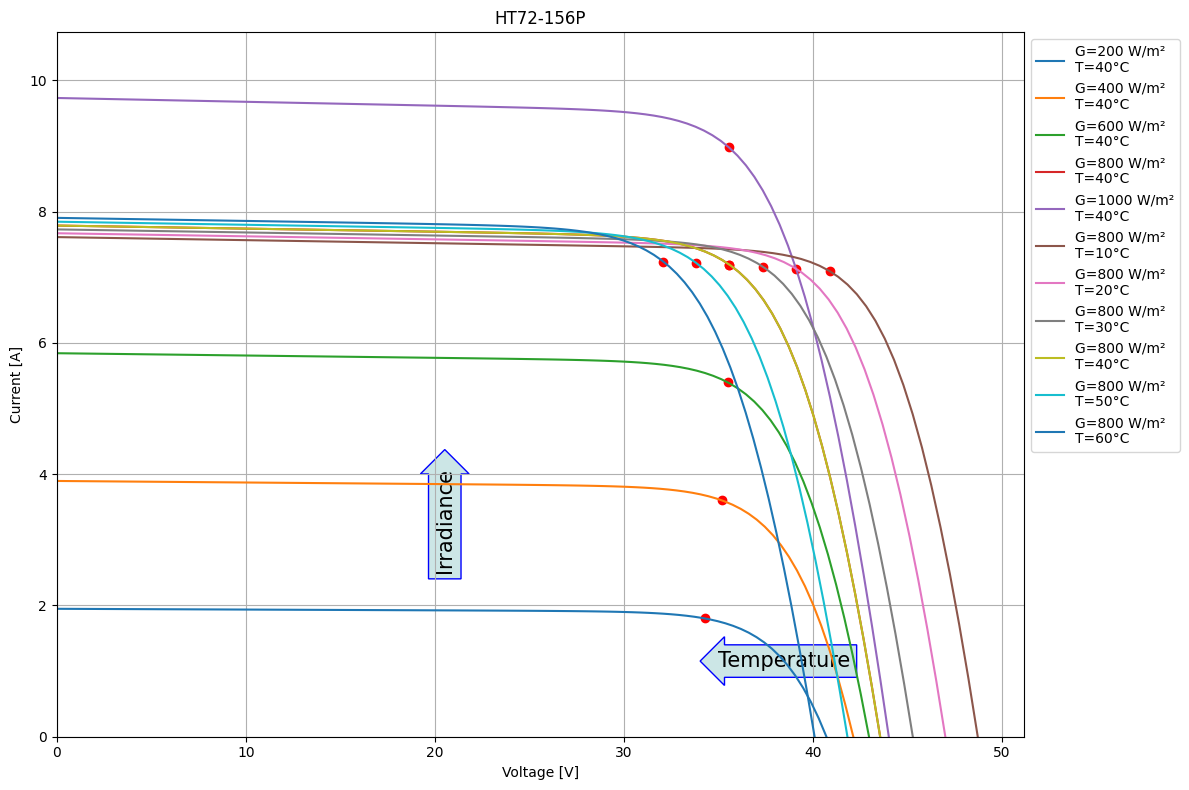

        i_sc       v_oc      i_mp       v_mp        p_mp
0   1.948586  40.730493  1.801468  34.300163   61.790656
1   3.895857  42.152721  3.602026  35.180156  126.719827
2   5.841814  42.984671  5.398478  35.503410  191.664388
3   7.786460  43.574948  7.190094  35.599717  255.965320
4   9.729794  44.032803  8.976369  35.572716  319.313837
5   7.610730  48.740602  7.090331  40.913421  290.089716
6   7.669306  47.024337  7.126748  39.135215  278.906802
7   7.727883  45.302383  7.160136  37.363696  267.529161
8   7.786460  43.574948  7.190094  35.599717  255.965320
9   7.845036  41.842229  7.216147  33.844205  244.224757
10  7.903613  40.104406  7.237735  32.098174  232.318066


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib.ivtools import sdm

# --------------------------
# Module and Inverter Parameters
# --------------------------

# Module Parameters
module_parameters = {
    'Name': 'HT72-156P',
    'pdc0': 340,  # DC power output at standard test conditions (W)
    'gamma_pdc': -0.0041,  # Temperature coefficient of power (%/°C)
    'b': -0.0041,  # Temperature coefficient of power (%/°C) - alias
    'BIPV': 'N',
    'Date': '2018',
    'T_NOCT': 45,
    'A_c': 1.656 * 0.992,  # Module area in m²
    'N_s': 72,
    'I_sc_ref': 9.62,  # Short-circuit current at STC (A)
    'V_oc_ref': 46.6,  # Open-circuit voltage at STC (V)
    'I_mp_ref': 8.92,  # Current at MPP at STC (A)
    'V_mp_ref': 38.2,  # Voltage at MPP at STC (V)
    'alpha_sc': 0.0050,  # Temperature coefficient of I_sc (%/°C)
    'beta_oc': -0.32,  # Temperature coefficient of V_oc (%/°C)
    'gamma_r': -0.41,  # Temperature coefficient of power (%/°C)
    'cells_in_series': 72,
    'R_s': 0.01,   # Series resistance (Ohms)
    'R_sh_ref': 1000,  # Shunt resistance (Ohms)
    'N': 1.2,  # Ideality factor (dimensionless)
    'temp_ref': 25  # Reference temperature (K)
}

# Inverter Parameters
inverter_parameters = {
    'Name': 'Vacon 8000 Solar 1250 kW',
    'Vac': 400,  # Line-to-line voltage (V)
    'Paco': 1250000,  # AC output power (W)
    'Pdco': 1268681.23,  # DC input power (W)
    'Vdco': 410,  # DC voltage at which inverter operates at maximum efficiency (V)
    'Pso': 30,  # Self-consumption power at night (W)
    'C0': -0.00001,
    'C1': 0.001,
    'C2': -0.000005,
    'C3': 0,
    'Pnt': 0.1,  # Power consumed at night (W)
    'Vdcmax': 900,  # Maximum DC voltage (V)
    'Idcmax': 353,  # Maximum DC current (A)
    'Mppt_low': 410,  # Minimum MPPT voltage (V)
    'Mppt_high': 800,  # Maximum MPPT voltage (V)
    'pdc0': 1250000
}

# --------------------------
# Fitting the CEC Single Diode Model
# --------------------------

# Step 1: Estimating the parameters for the CEC single diode model
# WARNING: This function relies on NREL's SAM tool via PySAM. Ensure PySAM is installed.
cec_fit_params = sdm.fit_cec_sam(
    'multiSi',
    module_parameters['V_mp_ref'],
    module_parameters['I_mp_ref'],
    module_parameters['V_oc_ref'],
    module_parameters['I_sc_ref'],
    module_parameters['alpha_sc'],
    module_parameters['beta_oc'],
    module_parameters['gamma_r'],
    module_parameters['cells_in_series'],
    module_parameters['temp_ref'],
)

print("CEC Fit Parameters:")
print(f"i_l_ref: {cec_fit_params[0]:.6e} A")
print(f"i_o_ref: {cec_fit_params[1]:.6e} A")
print(f"r_s: {cec_fit_params[2]:.6f} Ohms")
print(f"r_sh_ref: {cec_fit_params[3]:.6f} Ohms")
print(f"a_ref: {cec_fit_params[4]:.6f}")
print(f"adjust: {cec_fit_params[5]:.6f}%")

# Scenario 1: Varying Irradiance with Constant Temperature (40°C)
irrad_varying = np.array([200, 400, 600, 800, 1000])  # Irradiance in W/m²
temp_cell_varying_irrad = np.array([40, 40, 40, 40, 40])  # Temperature in °C

# Scenario 2: Varying Temperature with Constant Irradiance (800 W/m²)
irrad_varying_temp = np.array([800, 800, 800, 800, 800, 800])  # Irradiance in W/m²
temp_cell_varying_temp = np.array([10, 20, 30, 40, 50, 60])  # Temperature in °C

# Combine both scenarios into a single DataFrame for plotting
conditions = pd.DataFrame({
    'Geff': np.concatenate([irrad_varying, irrad_varying_temp]),
    'Tcell': np.concatenate([temp_cell_varying_irrad, temp_cell_varying_temp])
})

# Assign a unique label for each condition
conditions['Label'] = conditions.apply(
    lambda row: f"G={row['Geff']} W/m²\nT={row['Tcell']}°C",
    axis=1
)

# --------------------------
# Calculating Diode Parameters Using the CEC Model
# --------------------------

# Initialize DataFrames to store voltage and current for all conditions
v = pd.DataFrame()
i = pd.DataFrame()

# Initialize a list to store curve information for all conditions
curve_info_list = []

for idx, case in conditions.iterrows():
    Geff = case['Geff']
    Tcell = case['Tcell']
    
    # Calculate diode parameters using calcparams_cec
    diode_params = pvlib.pvsystem.calcparams_cec(
        Geff,
        Tcell,
        module_parameters['alpha_sc'],
        cec_fit_params[4],     # a_ref
        cec_fit_params[0],   # i_l_ref
        cec_fit_params[1],   # i_o_ref
        cec_fit_params[3],  # r_sh_ref
        cec_fit_params[2],       # r_s
        cec_fit_params[5]      # adjust
    )
    
    # Define SDE_params as a dictionary
    SDE_params = {
        'photocurrent': diode_params[0],
        'saturation_current': diode_params[1],
        'resistance_series': diode_params[2],
        'resistance_shunt': diode_params[3],
        'a_ref': diode_params[4]
    }
    
    # Run the single-diode model using 'lambertw' method
    curve_info = pvlib.pvsystem.singlediode(
        SDE_params['photocurrent'],
        SDE_params['saturation_current'],
        SDE_params['resistance_series'],
        SDE_params['resistance_shunt'],
        SDE_params['a_ref'],   
        method='lambertw'           # Using Lambert W method
    )
    
    # Store curve_info for later use
    curve_info_list.append(curve_info)
    
    # Generate voltage array from 0 to v_oc
    voltage = np.linspace(0, curve_info['v_oc'], 100)
    
    # Calculate current using i_from_v
    current = pvlib.pvsystem.i_from_v(
        voltage,
        SDE_params['photocurrent'],
        SDE_params['saturation_current'],
        SDE_params['resistance_series'],
        SDE_params['resistance_shunt'],
        SDE_params['a_ref'],
        method='lambertw'
    )
    
    # Add to DataFrames
    v[idx] = voltage
    i[idx] = current

# --------------------------
# Plotting I-V Characteristics
# --------------------------

plt.figure(figsize=(12, 8))

for idx, case in conditions.iterrows():
    plt.plot(v[idx], i[idx], label=case['Label'])
    plt.scatter(curve_info_list[idx]['v_mp'], curve_info_list[idx]['i_mp'], color='red')  # MPP Point

plt.title(module_parameters['Name'])
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.ylim(0, max(i.max()) + 1)
plt.xlim(left=0)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True)

# Draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation,
                size=size, bbox=bbox_props, zorder=-1)

ax = plt.gca()
draw_arrow(ax, 'Irradiance', 20, 2.5, 90, 15, 'r')
draw_arrow(ax, 'Temperature', 35, 1, 0, 15, 'l')
plt.tight_layout()
plt.show()

# --------------------------
# Displaying Curve Information
# --------------------------

curve_info_df = pd.DataFrame({
    'i_sc': [ci['i_sc'] for ci in curve_info_list],
    'v_oc': [ci['v_oc'] for ci in curve_info_list],
    'i_mp': [ci['i_mp'] for ci in curve_info_list],
    'v_mp': [ci['v_mp'] for ci in curve_info_list],
    'p_mp': [ci['p_mp'] for ci in curve_info_list],
})

print(curve_info_df)

Calculated Duty Cycle: 0.9070


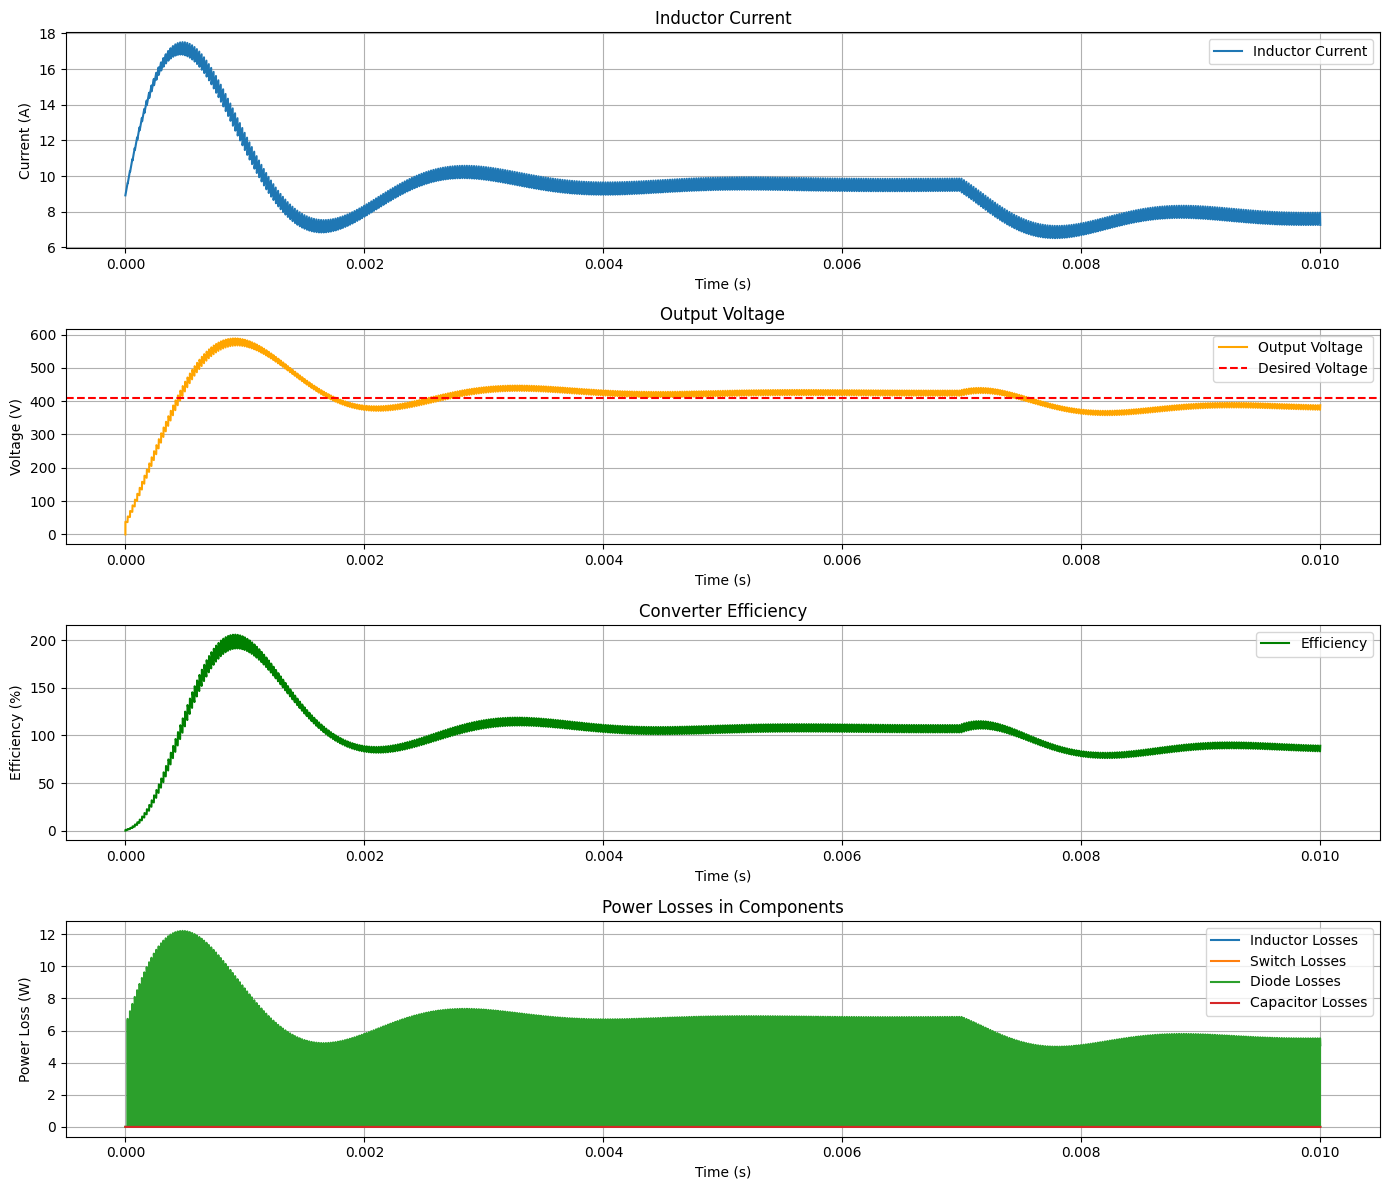

Final Output Voltage: 387.74 V
Final Converter Efficiency: 98.51%
Total Power Losses: 5.09 W


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 1. Define Parameters
# --------------------------

# Input Parameters
V_in = 38.2      # Input voltage (V)
I_in = 8.92      # Input current (A)
P_in = V_in * I_in  # Input power (W)

# Desired Output Voltage
V_out_desired = 410.0  # Output voltage (V)

# Component Values
L = 1e-3          # Inductance (H)
C = 1e-6        # Capacitance (F)
R_L = 1e-6         # Inductor resistance (Ω)
R_switch = 1e-6   # Switch resistance (Ω)
V_diode = 0.7     # Diode forward voltage (V)
R_diode = 1e-6   # Diode resistance (Ω)
R_C = 1e-6        # Capacitor ESR (Ω)

# Load Resistance
P_out = P_in  # Assuming ideal converter for initial calculation
I_out = P_out / V_out_desired
R_load = V_out_desired / I_out

# Switching Parameters
f_s = 50e3        # Switching frequency (Hz)
T_s = 1 / f_s     # Switching period (s)
dt = T_s / 100    # Time step (s)
t_total = 0.01     # Total simulation time (s)
time_steps = int(t_total / dt)
time = np.linspace(0, t_total, time_steps)

# Initial Duty Cycle Calculation
D = 1 - (V_in) / (V_out_desired + V_diode)
D = np.clip(D, 0.0, 0.99)  # Clamp between 0 and 0.99
print(f"Calculated Duty Cycle: {D:.4f}")

# --------------------------
# 2. Initialize Arrays
# --------------------------

i_L = np.zeros(time_steps)       # Inductor current (A)
v_C = np.zeros(time_steps)       # Capacitor voltage (V)
v_out = np.zeros(time_steps)     # Output voltage (V)
i_load = np.zeros(time_steps)    # Load current (A)
state = np.zeros(time_steps)     # Switch state (1=ON, 0=OFF)

# Power Variables
P_in_array = np.zeros(time_steps)
P_out_array = np.zeros(time_steps)
P_loss_inductor = np.zeros(time_steps)
P_loss_switch = np.zeros(time_steps)
P_loss_diode = np.zeros(time_steps)
P_loss_capacitor = np.zeros(time_steps)
P_total_losses = np.zeros(time_steps)
efficiency = np.zeros(time_steps)

# Initial Conditions
i_L[0] = I_in    # Start with input current
v_C[0] = V_in    # Start with input voltage
v_out[0] = 0     # Output voltage starts at 0

# --------------------------
# 3. Simulation Loop
# --------------------------

for t in range(1, time_steps):
    # Determine switch state
    t_in_period = (time[t] % T_s) / T_s
    if t_in_period < D:
        # Switch is ON
        state[t] = 1
        V_L = V_in - i_L[t - 1] * (R_L + R_switch)
        di_L = (V_L / L) * dt
        i_L[t] = i_L[t - 1] + di_L

        # Capacitor discharges through the load
        i_load[t] = v_C[t - 1] / R_load
        i_C = -i_load[t]
        dv_C = (i_C / C) * dt
        v_C[t] = v_C[t - 1] + dv_C

        # Power losses
        P_loss_switch[t] = i_L[t] ** 2 * R_switch
        P_loss_diode[t] = 0
    else:
        # Switch is OFF
        state[t] = 0
        V_L = V_in - v_C[t - 1] - V_diode - i_L[t - 1] * (R_L + R_diode)
        di_L = (V_L / L) * dt
        i_L[t] = i_L[t - 1] + di_L

        # Capacitor charges from inductor current minus load current
        i_load[t] = v_C[t - 1] / R_load
        i_C = i_L[t - 1] - i_load[t]
        dv_C = (i_C / C) * dt
        v_C[t] = v_C[t - 1] + dv_C

        # Power losses
        P_loss_switch[t] = 0
        P_loss_diode[t] = i_L[t] ** 2 * R_diode + i_L[t] * V_diode

    # Inductor losses
    P_loss_inductor[t] = i_L[t] ** 2 * R_L

    # Capacitor losses
    P_loss_capacitor[t] = i_C ** 2 * R_C

    # Ensure non-negative values
    i_L[t] = max(i_L[t], 0)
    v_C[t] = max(v_C[t], 0)
    v_out[t] = v_C[t]  # Assuming output voltage equals capacitor voltage

    # Power calculations
    P_in_array[t] = V_in * I_in  # Input power remains constant in this model
    P_out_array[t] = v_out[t] * i_load[t]
    P_total_losses[t] = P_loss_inductor[t] + P_loss_switch[t] + P_loss_diode[t] + P_loss_capacitor[t]
    efficiency[t] = (P_out_array[t] / P_in_array[t]) * 100

# --------------------------
# 4. Plotting Results
# --------------------------

plt.figure(figsize=(14, 12))

# Inductor Current
plt.subplot(4, 1, 1)
plt.plot(time, i_L, label='Inductor Current')
plt.title('Inductor Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.grid(True)
plt.legend()

# Output Voltage
plt.subplot(4, 1, 2)
plt.plot(time, v_out, label='Output Voltage', color='orange')
plt.axhline(y=V_out_desired, color='red', linestyle='--', label='Desired Voltage')
plt.title('Output Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

# Efficiency
plt.subplot(4, 1, 3)
plt.plot(time, efficiency, label='Efficiency', color='green')
plt.title('Converter Efficiency')
plt.xlabel('Time (s)')
plt.ylabel('Efficiency (%)')
plt.grid(True)
plt.legend()

# Power Losses
plt.subplot(4, 1, 4)
plt.plot(time, P_loss_inductor, label='Inductor Losses')
plt.plot(time, P_loss_switch, label='Switch Losses')
plt.plot(time, P_loss_diode, label='Diode Losses')
plt.plot(time, P_loss_capacitor, label='Capacitor Losses')
plt.title('Power Losses in Components')
plt.xlabel('Time (s)')
plt.ylabel('Power Loss (W)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# --------------------------
# 5. Final Outputs
# --------------------------

print(f"Final Output Voltage: {v_out[-1]:.2f} V")
print(f"Final Converter Efficiency: {(P_in - P_total_losses[-1])/P_in*100:.2f}%")
print(f"Total Power Losses: {P_total_losses[-1]:.2f} W")

eff = (P_in - P_total_losses[-1])/P_in

EMI Filter Cut-off Frequency: 1014.7 Hz


/var/folders/37/hdkky04n2t1dq_8gqccxyxf00000gn/T/ipykernel_80809/3662097509.py:222: RuntimeWarning: invalid value encountered in divide
  efficiency = (P_out_total / P_in_total) * 100


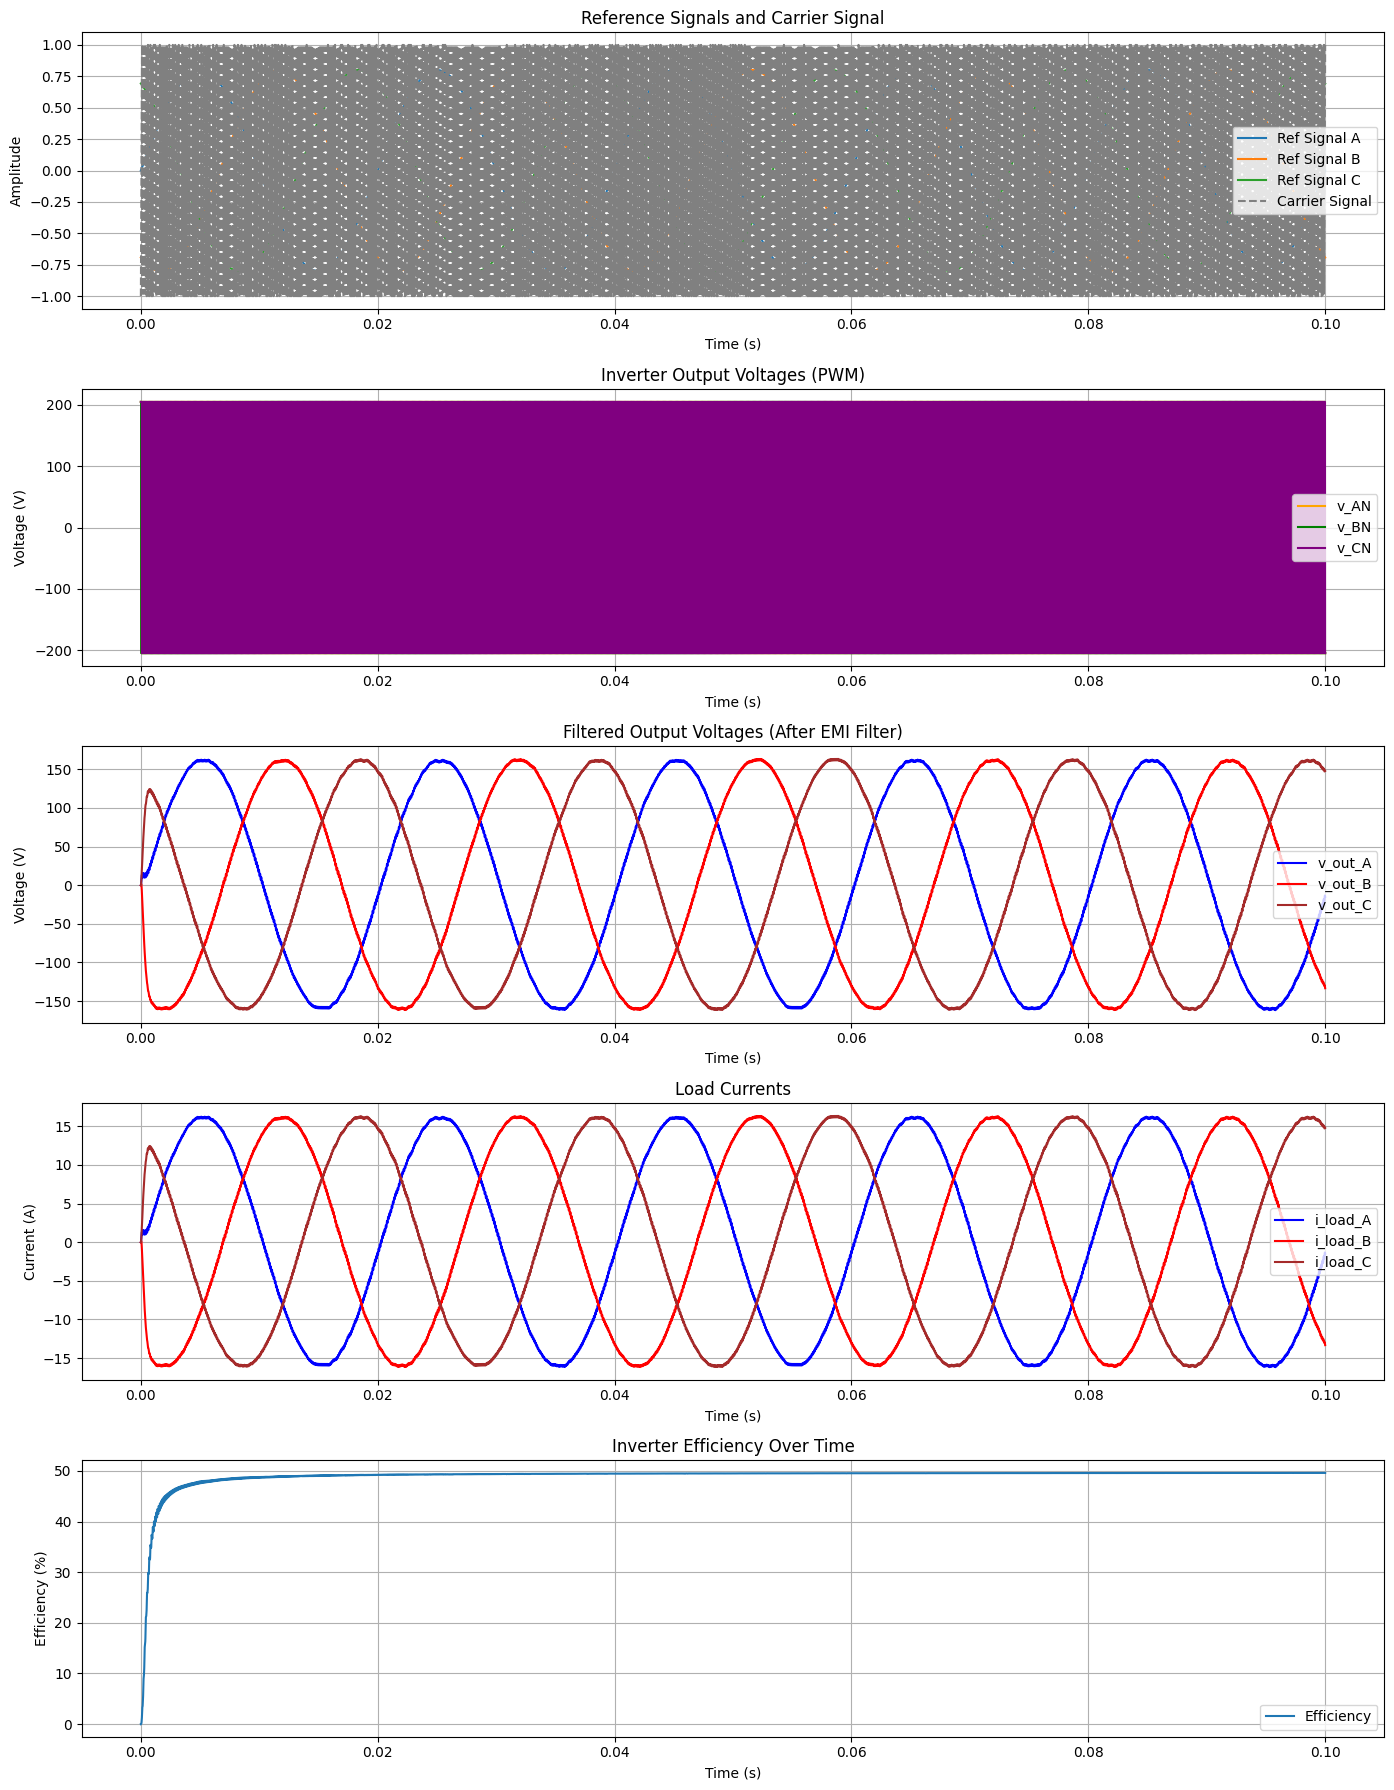

Final Efficiency: 49.59%
Total Power Losses: 4.56 W


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# 1. System Parameters
# --------------------------

# DC Input Voltage
V_DC = 410.0        # DC input voltage from the DC-DC converter (V)

# Frequencies
f_out = 50          # Desired output AC frequency (Hz)
f_carrier = 10e3    # Carrier frequency for PWM (Hz)

# Load Parameters
R_load = 10.0       # Load resistance per phase (Ω)
L_load = 5e-3       # Load inductance per phase (H)

# EMI Filter Parameters (per phase)
L_f = 3e-3          # Filter inductance (H)
C_f = 8.2e-6        # Filter capacitance (F)

# Calculate cut-off frequency
f_c = 1 / (2 * np.pi * np.sqrt(L_f * C_f))
print(f"EMI Filter Cut-off Frequency: {f_c:.1f} Hz")

# Simulation Parameters
t_total = 0.1                 # Total simulation time (s)
fs = 100 * f_carrier          # Sampling frequency (Hz)
dt = 1 / fs                   # Time step (s)
time = np.arange(0, t_total, dt)
time_steps = len(time)

# Modulation Index
m_a = 0.8                     # Modulation index (0 < m_a ≤ 1)

# --------------------------
# 2. Generate Reference and Carrier Signals
# --------------------------

# Reference Signals (Three-phase sine waves)
omega_out = 2 * np.pi * f_out
ref_signal_A = m_a * np.sin(omega_out * time)
ref_signal_B = m_a * np.sin(omega_out * time - (2/3)*np.pi)  # -120 degrees
ref_signal_C = m_a * np.sin(omega_out * time - (4/3)*np.pi)  # -240 degrees

# Carrier Signal (Triangular wave)
carrier_signal = 2 * (time * f_carrier % 1) - 1  # Triangular wave between -1 and 1

# --------------------------
# 3. Generate PWM Signals using SPWM
# --------------------------

# Initialize Gate Signals for IGBTs
gate_P1 = np.zeros(time_steps)
gate_P2 = np.zeros(time_steps)
gate_P3 = np.zeros(time_steps)
gate_N1 = np.zeros(time_steps)
gate_N2 = np.zeros(time_steps)
gate_N3 = np.zeros(time_steps)

# Generate PWM Signals
for t in range(time_steps):
    # Phase A
    if ref_signal_A[t] >= carrier_signal[t]:
        gate_P1[t] = 1
        gate_N1[t] = 0
    else:
        gate_P1[t] = 0
        gate_N1[t] = 1
    # Phase B
    if ref_signal_B[t] >= carrier_signal[t]:
        gate_P2[t] = 1
        gate_N2[t] = 0
    else:
        gate_P2[t] = 0
        gate_N2[t] = 1
    # Phase C
    if ref_signal_C[t] >= carrier_signal[t]:
        gate_P3[t] = 1
        gate_N3[t] = 0
    else:
        gate_P3[t] = 0
        gate_N3[t] = 1

# --------------------------
# 4. Inverter Output Voltages (Line-to-Neutral)
# --------------------------

# Initialize Inverter Output Voltages
v_AN = np.zeros(time_steps)
v_BN = np.zeros(time_steps)
v_CN = np.zeros(time_steps)

V_p = V_DC / 2  # Positive DC bus voltage
V_n = -V_DC / 2  # Negative DC bus voltage

for t in range(time_steps):
    # Phase A
    if gate_P1[t] == 1:
        v_AN[t] = V_p
    else:
        v_AN[t] = V_n

    # Phase B
    if gate_P2[t] == 1:
        v_BN[t] = V_p
    else:
        v_BN[t] = V_n

    # Phase C
    if gate_P3[t] == 1:
        v_CN[t] = V_p
    else:
        v_CN[t] = V_n

# --------------------------
# 5. EMI Filter and Load Modeling
# --------------------------

# Initialize Filter Currents and Output Voltages
i_f_A = np.zeros(time_steps)
v_out_A = np.zeros(time_steps)
i_load_A = np.zeros(time_steps)

i_f_B = np.zeros(time_steps)
v_out_B = np.zeros(time_steps)
i_load_B = np.zeros(time_steps)

i_f_C = np.zeros(time_steps)
v_out_C = np.zeros(time_steps)
i_load_C = np.zeros(time_steps)

# Inductor Resistance
R_Lf = 0.1  # Ω (Filter inductor resistance)

# Simulation Loop for EMI Filter and Load
for t in range(1, time_steps):
    # Phase A
    v_Lf_A = v_AN[t-1] - v_out_A[t-1] - i_f_A[t-1] * R_Lf  # Include inductor resistance
    di_f_A = (v_Lf_A / L_f) * dt
    i_f_A[t] = i_f_A[t-1] + di_f_A

    v_Cf_A = v_out_A[t-1]
    i_load_A[t] = v_Cf_A / R_load  # Assuming purely resistive load for simplicity
    dv_out_A = ((i_f_A[t] - i_load_A[t]) / C_f) * dt
    v_out_A[t] = v_out_A[t-1] + dv_out_A

    # Phase B
    v_Lf_B = v_BN[t-1] - v_out_B[t-1] - i_f_B[t-1] * R_Lf
    di_f_B = (v_Lf_B / L_f) * dt
    i_f_B[t] = i_f_B[t-1] + di_f_B

    v_Cf_B = v_out_B[t-1]
    i_load_B[t] = v_Cf_B / R_load
    dv_out_B = ((i_f_B[t] - i_load_B[t]) / C_f) * dt
    v_out_B[t] = v_out_B[t-1] + dv_out_B

    # Phase C
    v_Lf_C = v_CN[t-1] - v_out_C[t-1] - i_f_C[t-1] * R_Lf
    di_f_C = (v_Lf_C / L_f) * dt
    i_f_C[t] = i_f_C[t-1] + di_f_C

    v_Cf_C = v_out_C[t-1]
    i_load_C[t] = v_Cf_C / R_load
    dv_out_C = ((i_f_C[t] - i_load_C[t]) / C_f) * dt
    v_out_C[t] = v_out_C[t-1] + dv_out_C

# --------------------------
# 6. Physical Loss Calculations
# --------------------------

# IGBT Parameters
V_CEsat = 0.2     # V (Collector-Emitter saturation voltage)
R_on = 1e-6       # Ω (On-state resistance)
E_on = 1e-6       # J (Switching energy loss during turn-on)
E_off = 1e-6      # J (Switching energy loss during turn-off)

# Conduction Losses in IGBTs
P_cond_IGBT = np.zeros(time_steps)
for t in range(time_steps):
    I_upper = np.array([i_f_A[t] if gate_P1[t] == 1 else 0,
                        i_f_B[t] if gate_P2[t] == 1 else 0,
                        i_f_C[t] if gate_P3[t] == 1 else 0])
    I_lower = np.array([-i_f_A[t] if gate_N1[t] == 1 else 0,
                        -i_f_B[t] if gate_N2[t] == 1 else 0,
                        -i_f_C[t] if gate_N3[t] == 1 else 0])
    I_total = np.concatenate((I_upper, I_lower))
    P_cond_IGBT[t] = np.sum(V_CEsat * np.abs(I_total) + R_on * I_total ** 2)

# Switching Losses in IGBTs (Assuming constant per switching event)
P_sw_IGBT = (E_on + E_off) * f_carrier * 6  # Total for 6 IGBTs (assumed constant over time)

# Total IGBT Losses
P_IGBT_losses = P_cond_IGBT + P_sw_IGBT

# Diode Losses (Assuming negligible for simplicity)

# Filter Inductor Losses
P_loss_Lf = (i_f_A ** 2 + i_f_B ** 2 + i_f_C ** 2) * R_Lf

# Total Losses
P_total_losses = P_IGBT_losses + P_loss_Lf

# --------------------------
# 7. Output Power and Efficiency
# --------------------------

# Output Power
P_out = v_out_A * i_load_A + v_out_B * i_load_B + v_out_C * i_load_C

# Input Power
I_in = (gate_P1 * i_f_A + gate_P2 * i_f_B + gate_P3 * i_f_C) - (gate_N1 * i_f_A + gate_N2 * i_f_B + gate_N3 * i_f_C)
P_in = V_DC * I_in

# Cumulative Power
P_in_total = np.cumsum(P_in) * dt
P_out_total = np.cumsum(P_out) * dt
P_loss_total = np.cumsum(P_total_losses) * dt

# Efficiency
efficiency = (P_out_total / P_in_total) * 100

# --------------------------
# 8. Plotting Results
# --------------------------

plt.figure(figsize=(14, 18))

# Reference Signals and Carrier
plt.subplot(5, 1, 1)
plt.plot(time, ref_signal_A, label='Ref Signal A')
plt.plot(time, ref_signal_B, label='Ref Signal B')
plt.plot(time, ref_signal_C, label='Ref Signal C')
plt.plot(time, carrier_signal, label='Carrier Signal', linestyle='--', color='gray')
plt.title('Reference Signals and Carrier Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Inverter Output Voltages (PWM)
plt.subplot(5, 1, 2)
plt.plot(time, v_AN, label='v_AN', color='orange')
plt.plot(time, v_BN, label='v_BN', color='green')
plt.plot(time, v_CN, label='v_CN', color='purple')
plt.title('Inverter Output Voltages (PWM)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

# Filtered Output Voltages
plt.subplot(5, 1, 3)
plt.plot(time, v_out_A, label='v_out_A', color='blue')
plt.plot(time, v_out_B, label='v_out_B', color='red')
plt.plot(time, v_out_C, label='v_out_C', color='brown')
plt.title('Filtered Output Voltages (After EMI Filter)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)

# Phase Currents
plt.subplot(5, 1, 4)
plt.plot(time, i_load_A, label='i_load_A', color='blue')
plt.plot(time, i_load_B, label='i_load_B', color='red')
plt.plot(time, i_load_C, label='i_load_C', color='brown')
plt.title('Load Currents')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True)

# Efficiency Over Time
plt.subplot(5, 1, 5)
plt.plot(time, efficiency, label='Efficiency')
plt.title('Inverter Efficiency Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Efficiency (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# --------------------------
# 9. Final Outputs
# --------------------------

print(f"Final Efficiency: {efficiency[-1]:.2f}%")
print(f"Total Power Losses: {P_loss_total[-1]:.2f} W")